# Supporting Calculations and Executions for ML Model of Auto Insurence

      PLEASE IGNORE THE AUDIO IN THIS FILE, IT WAS INCLUDED AS AN ALARM WHEN THE CODE EXECUTION IS COMPLETE

## Section 1: Import the required Libraries & Read the Data

In [77]:
########################################### IMPORT ALL THE REQUIRED LIBRARIES ###########################################
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error , r2_score, accuracy_score,confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from xgboost import plot_importance
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.neural_network import MLPClassifier
from IPython.display import Audio
sound_file ="Neene Modalu.mp3"

In [2]:
########################################### READ THE DATASET ###########################################
df = pd.read_csv("train.csv")
print("Shape of the Dataset: \n",df.shape)
df.head()  

Shape of the Dataset: 
 (595212, 59)


,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


## Section 2: User defined Functions

### Section 2.a: Function to run all the Classification Models

In [3]:
# Function to evaluate each model 
def run_models(spread,d_f,seed,Test_size):
    #Select and Add the Models
    models = []
    models.append(('XGBoo ', XGBClassifier()))
    models.append(('AdaBoo', AdaBoostClassifier(n_estimators=100, random_state=seed)))
    models.append(('LogReg', LogisticRegression(solver='liblinear', multi_class='ovr')))
    models.append(('LDA   ', LinearDiscriminantAnalysis()))
    models.append(('KNearN', KNeighborsClassifier()))
    models.append(('CART  ', DecisionTreeClassifier()))
    models.append(('NaiveB', GaussianNB()))
    models.append(('SupVec', SVC(gamma='auto', probability=True)))
    models.append(('RandFo', RandomForestClassifier(n_estimators=100)))
    
    #Seperate out Features & Target
    Y = d_f["target"]
    d_f = d_f.drop("target",axis =1)
    
    #Split Data into Test & Train
    X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(d_f, Y, test_size=Test_size,random_state=seed)
    Res_final =pd.DataFrame()
    for r in spread: # Select the Category of the Data Seperately
        results = []
        names = []
        F1_Scores =[]
        Auc_Scores =[]
        Train_Scores =[]
        Test_Scores =[]
        Precision_Scores_0=[]
        Precision_Scores_1=[]
        Recall_Scores_1 =[]
        Recall_Scores_0 =[]
        #print("=========================================================")
        #print("Scores for "+str(r)+" Variables: ")
        #print("=========================================================")
        q = spread[r]
        X_train1 = X_train.iloc[:,q[0]:q[-1]]
        X_validation1 = X_validation.iloc[:,q[0]:q[-1]]
        Y_train1 = Y_train
        Y_validation1 = Y_validation
        for name, model in models: # Run The Models with Selected Data Category
            #print("--------------------------------")
            m = model
            m.fit(X_train1, Y_train1)
            Trn_scr = np.round((m.score(X_train1, Y_train1)*100),2)
            #msg = "Train Score for :"+"%s: %.2f " % (name,Trn_scr)
            #print(msg)
            Train_Scores.append(Trn_scr)

            predictions = m.predict(X_validation1)
            Tst_scr = np.round((accuracy_score(Y_validation1, predictions)*100),2)
            #msg = "Test Score for  :"+"%s: %.2f" % (name, Tst_scr)
            #print(msg)
            Test_Scores.append(Tst_scr)

            conf_mat = confusion_matrix(Y_validation1, predictions)
            #print("Confusion Matrix: \n",conf_mat)
            
            CL_R = classification_report(Y_validation1, predictions)

            #print("F1 Score : ", np.round(F1,2))

            probs = m.predict_proba(X_validation1)
            
            # keep probabilities for the positive outcome only
            probs = probs[:, 1]
            # calculate scores
            auc = roc_auc_score(Y_validation1, probs)
            Auc_Scores.append(np.round(auc,2))
            #print("AUC Score: ",np.round(auc,2))

            tn = conf_mat[0][0]
            fp = conf_mat[0][1]
            fn = conf_mat[1][0]
            tp = conf_mat[1][1]

            precision_0 = np.round((tn/(tn+fn)),2)
            precision_1 = np.round((tp/(fp+tp)),2)                        
            recall_0 = np.round((tn/(tn+fp)),2)
            recall_1 = np.round((tp/(fn+tp)),2)
            
            F1 = 2*((precision_1*recall_1)/(precision_1+recall_1))
            F1_Scores.append(np.round(F1,2))
            
            Precision_Scores_0.append(precision_0) 
            Precision_Scores_1.append(precision_1)
            Recall_Scores_0.append(recall_0)
            Recall_Scores_1.append(recall_1)
        
        # summarize scores for selected Category for all the Models
        #print("####################### ",str(r)," Summary #######################")
        Res_Intmdt = pd.DataFrame()
        Res_Intmdt["Model"] = pd.DataFrame(models).iloc[:,0]
        Res_Intmdt["Var"] = str(r)
        Res_Intmdt["Train"] = pd.DataFrame(Train_Scores)
        Res_Intmdt["Test"] = pd.DataFrame(Test_Scores)
        Res_Intmdt["Pre0"] = pd.DataFrame(Precision_Scores_0)
        Res_Intmdt["Pre1"] = pd.DataFrame(Precision_Scores_1)
        Res_Intmdt["Rec0"] = pd.DataFrame(Recall_Scores_0)
        Res_Intmdt["Rec1"] = pd.DataFrame(Recall_Scores_1)
        Res_Intmdt["F1"] = pd.DataFrame(F1_Scores)
        Res_Intmdt["AUC"] = pd.DataFrame(Auc_Scores)
        #print(Res_Intmdt)
        #print("####################### End of Summary #######################")
        
        # summarize scores for the Categories for all the Models
        Res_final=pd.concat([Res_final,Res_Intmdt], axis=0)
        #print("=========================================================")
    #print("")
    #print("################################## Final Summary ##################################")
    #print(Res_final)
    #print("################################## End of Summary ##################################")
    return conf_mat, CL_R, Res_final

### Section 2.b: Function to run Random Forest Model

In [40]:
def run_RF(X_tr, X_val, Y_tr,Y_val, var1):
    m = RandomForestClassifier(n_estimators=600)
    m.fit(X_tr, Y_tr)
    Trn_scr = np.round((m.score(X_tr, Y_tr)*100),2)
    #msg = "Train Score for :"+"%.2f " % (Trn_scr)

    predictions = m.predict(X_val)
    Tst_scr = np.round((accuracy_score(Y_val, predictions)*100),2)
    #msg = "Test Score for  :"+"%.2f" % (Tst_scr)
    #print(msg)

    conf_mat = confusion_matrix(Y_val, predictions)
    #print("Confusion Matrix: \n",conf_mat)
    
    CL_R = classification_report(Y_val, predictions)

    #F1 = np.round(f1_score(Y_val, predictions),2)
    #print("F1 Score : ", np.round(F1,2))

    probs = m.predict_proba(X_val)
    # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    # calculate scores
    auc = np.round(roc_auc_score(Y_val, probs),2)
    # summarize scores
    #print("AUC Score: ",np.round(auc,2))

    tn = conf_mat[0][0]
    fp = conf_mat[0][1]
    fn = conf_mat[1][0]
    tp = conf_mat[1][1]

    precision_0 = np.round((tn/(tn+fn)),2)
    precision_1 = np.round((tp/(fp+tp)),2)                        
    recall_0 = np.round((tn/(tn+fp)),2)
    recall_1 = np.round((tp/(fn+tp)),2)
            
    F1 = 2*((precision_1*recall_1)/(precision_1+recall_1))
    

    Res_Intmdt1 = pd.DataFrame()
    Res_Intmdt1["Model"] = ["RandFo"]
    Res_Intmdt1["Var"] = [str(var1)]
    Res_Intmdt1["Train"] = [np.round(Trn_scr,2)]
    Res_Intmdt1["Test"] = [np.round(Tst_scr,2)]
    Res_Intmdt1["Pre0"] = [np.round(precision_0,2)]
    Res_Intmdt1["Pre1"] = [np.round(precision_1,2)]
    Res_Intmdt1["Rec0"] = [np.round(recall_0,2)]
    Res_Intmdt1["Rec1"] = [np.round(recall_1,2)]
    Res_Intmdt1["F1"] = [np.round(F1,2)]
    Res_Intmdt1["AUC"] = [np.round(auc,2)]
    return conf_mat, CL_R, Res_Intmdt1

### Section 2.c: Function to Generate the Sequence of reducing 2/3 s

In [5]:
def two_third(n):
    n1 = np.round(n*(2/3),0)   
    t_3n.append(int(n1))
    if n1!=1:
        two_third(n1)         
    return t_3n

### Section 2.d: Function to run MLP for various architectures and iterations

In [175]:
def run_mlp(hid_architecture, epochs,X,Y, nn=False):
    X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=0.3,random_state=7)
    Res_final =pd.DataFrame()
    ln1 = len(epochs)
    for h in hid_architecture:
        F1_Scores =[]
        Auc_Scores =[]
        Train_Scores =[]
        Test_Scores =[]
        Loss_Scores =[]
        Precision_Scores_0=[]
        Precision_Scores_1=[]
        Recall_Scores_1 =[]
        Recall_Scores_0 =[]
        for e in epochs:
            MLCP = MLPClassifier(hidden_layer_sizes=h, max_iter=e, alpha=1e-4,
                                solver='adam', tol=1e-4, random_state=7,
                                learning_rate_init=0.1, activation ='relu')

            MLCP.fit(X, Y)

            predictions = MLCP.predict(X_validation)
            #prob_results = MLCP.predict_proba(X_validation)

            Trn_scr = np.round(MLCP.score(X_train, Y_train)*100,2)
            Tst_scr = np.round((accuracy_score(Y_validation, predictions)*100),2)
            
            Train_Scores.append(np.round(Trn_scr,2))
            Test_Scores.append(np.round(Tst_scr,2))

            conf_mat = confusion_matrix(Y_validation,predictions)
            CL_R = classification_report(Y_validation,predictions)
            
            Loss_Scores.append(np.round(MLCP.loss_curve_[-1],2))

            probs = MLCP.predict_proba(X_validation)
            # keep probabilities for the positive outcome only
            probs = probs[:, 1]
            # calculate scores
            auc = roc_auc_score(Y_validation, probs)
            Auc_Scores.append(np.round(auc,2))
            # summarize scores
            #print("AUC Score: ",np.round(auc,2))

            tn = conf_mat[0][0]
            fp = conf_mat[0][1]
            fn = conf_mat[1][0]
            tp = conf_mat[1][1]

            precision_0 = np.round((tn/(tn+fn)),2)
            precision_1 = np.round((tp/(fp+tp)),2)                        
            recall_0 = np.round((tn/(tn+fp)),2)
            recall_1 = np.round((tp/(fn+tp)),2)
            
            F1 = 2*((precision_1*recall_1)/(precision_1+recall_1))
            F1_Scores.append(np.round(F1,2))

            Precision_Scores_0.append(precision_0) 
            Precision_Scores_1.append(precision_1)
            Recall_Scores_0.append(recall_0)
            Recall_Scores_1.append(recall_1)

        #print("####################### ",str(r)," Summary #######################")
        Res_Intmdt = pd.DataFrame()
        #
        if nn == True:
            w = int(np.sum(h))
            Res_Intmdt["Arch"] = [w]*len(epochs)
        else:
            w = [str(1)+":"+str(len(h))+":"+str(1)]*ln1
            Res_Intmdt["Arch"] = w
        
        Res_Intmdt["Epoch"] = epochs
        Res_Intmdt["Train"] = pd.DataFrame(Train_Scores)
        Res_Intmdt["Test"] = pd.DataFrame(Test_Scores)
        Res_Intmdt["Loss"] = pd.DataFrame(Loss_Scores)
        Res_Intmdt["Pre0"] = pd.DataFrame(Precision_Scores_0)
        Res_Intmdt["Pre1"] = pd.DataFrame(Precision_Scores_1)
        Res_Intmdt["Rec0"] = pd.DataFrame(Recall_Scores_0)
        Res_Intmdt["Rec1"] = pd.DataFrame(Recall_Scores_1)
        Res_Intmdt["F1"] = pd.DataFrame(F1_Scores)
        Res_Intmdt["AUC"] = pd.DataFrame(Auc_Scores)
        #print(Res_Intmdt)
            #print("####################### End of Summary #######################")
        Res_final=pd.concat([Res_final,Res_Intmdt], axis=0)
        #print("=========================================================")
        #print("")
    #print("####################################### Final Summary #######################################")
    #print(Res_final)
    #print("####################################### End of Summary #######################################")
    return conf_mat, CL_R, Res_final

## Section 3: Data Preprocessing/Transformation

### Section 3.1: Classify the Features according to their as is Categories, Over Sample the Data & Select 100K data 

In [7]:
#Classify the Features according to their as is Categories
df_bin = df[["ps_calc_17_bin","ps_calc_16_bin","ps_calc_19_bin","ps_calc_18_bin","ps_ind_06_bin","ps_ind_17_bin","ps_ind_16_bin","ps_ind_07_bin","ps_calc_20_bin","ps_calc_15_bin","ps_ind_09_bin","ps_ind_08_bin","ps_ind_18_bin","ps_ind_12_bin","ps_ind_11_bin","ps_ind_13_bin","ps_ind_10_bin"]]
df_cat = df[["ps_car_11_cat","ps_car_06_cat","ps_car_01_cat","ps_ind_05_cat","ps_car_09_cat","ps_car_05_cat","ps_ind_02_cat","ps_car_03_cat","ps_ind_04_cat","ps_car_04_cat","ps_car_07_cat","ps_car_02_cat","ps_car_08_cat","ps_car_10_cat"]]
df_ind = df[["ps_ind_15","ps_ind_03","ps_ind_01","ps_ind_14"]]
df_car =df[["ps_car_13","ps_car_14","ps_car_15","ps_car_12","ps_car_11"]]
df_calc =df[["ps_calc_10","ps_calc_14","ps_calc_11","ps_calc_01","ps_calc_03","ps_calc_02","ps_calc_13","ps_calc_08","ps_calc_07","ps_calc_06","ps_calc_09","ps_calc_12","ps_calc_04","ps_calc_05"]]
df_reg = df[["ps_reg_03","ps_reg_02","ps_reg_01"]]

df1= pd.concat([df_bin, df_cat,df_ind,df_car,df_calc,df_reg], axis=1)
df1["target"] = df["target"]

#### Oversample the data and Select 100K records

In [8]:
#Over Sample the Data & Select 100K
count_class_0, count_class_1 = df1.target.value_counts()
df_class_0 = df1[df1["target"]== 0]
df_class_1 = df1[df1["target"]== 1]
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_over = pd.concat([df_class_0, df_class_1_over], axis=0)
df_class_0 = df_over[df_over["target"]== 0]
df_class_1 = df_over[df_over["target"]== 1]
df_final = pd.concat([df_class_0.sample(50000, replace=True), df_class_1.sample(50000, replace=True)], axis=0)
df_final1 = df_final.copy(deep=True)

#### Complete Raw Dataset

In [9]:
d_fF = df_final.copy(deep=True)
YF = d_fF["target"]
d_fF = d_fF.drop("target",axis =1)
X_trainF, X_validationF, Y_trainF, Y_validationF = model_selection.train_test_split(d_fF, YF, test_size=0.3,random_state=7)

#### DataSet Without Binary Variables

In [10]:
X_train2 = X_trainF.drop(["ps_calc_17_bin","ps_calc_16_bin","ps_calc_19_bin","ps_calc_18_bin","ps_ind_06_bin","ps_ind_17_bin","ps_ind_16_bin","ps_ind_07_bin","ps_calc_20_bin","ps_calc_15_bin","ps_ind_09_bin","ps_ind_08_bin","ps_ind_18_bin","ps_ind_12_bin","ps_ind_11_bin","ps_ind_13_bin","ps_ind_10_bin","ps_ind_15","ps_ind_03","ps_ind_01","ps_ind_14"], axis=1)
X_validation2 = X_validationF.drop(["ps_calc_17_bin","ps_calc_16_bin","ps_calc_19_bin","ps_calc_18_bin","ps_ind_06_bin","ps_ind_17_bin","ps_ind_16_bin","ps_ind_07_bin","ps_calc_20_bin","ps_calc_15_bin","ps_ind_09_bin","ps_ind_08_bin","ps_ind_18_bin","ps_ind_12_bin","ps_ind_11_bin","ps_ind_13_bin","ps_ind_10_bin","ps_ind_15","ps_ind_03","ps_ind_01","ps_ind_14"], axis=1)
Y_train2 = Y_trainF
Y_validation2 = Y_validationF


#### DataSet Without Binary & Reg Variables

In [11]:
X_train3 = X_train2.drop(["ps_reg_03","ps_reg_02","ps_reg_01"],axis=1)
X_validation3 = X_validation2.drop(["ps_reg_03","ps_reg_02","ps_reg_01"],axis=1)

#### DataSet Without Binary, Cat & Reg Variables

In [12]:
X_train4 = X_train3.drop(["ps_car_11_cat","ps_car_06_cat","ps_car_01_cat","ps_ind_05_cat","ps_car_09_cat","ps_car_05_cat","ps_ind_02_cat","ps_car_03_cat","ps_ind_04_cat","ps_car_04_cat","ps_car_07_cat","ps_car_02_cat","ps_car_08_cat","ps_car_10_cat"],axis=1)
X_validation4 = X_validation3.drop(["ps_car_11_cat","ps_car_06_cat","ps_car_01_cat","ps_ind_05_cat","ps_car_09_cat","ps_car_05_cat","ps_ind_02_cat","ps_car_03_cat","ps_ind_04_cat","ps_car_04_cat","ps_car_07_cat","ps_car_02_cat","ps_car_08_cat","ps_car_10_cat"],axis=1)

#### DataSet Without Binary, Cat, Car & Reg Variables

In [13]:
X_train5 = X_train4.drop(["ps_car_13","ps_car_14","ps_car_15","ps_car_12","ps_car_11"],axis=1)
X_validation5 = X_validation4.drop(["ps_car_13","ps_car_14","ps_car_15","ps_car_12","ps_car_11"],axis=1)

#### DataSet Without Binary, Cat, Car, Calc & Reg Variables

In [14]:
X_train6 = X_train4.drop(["ps_calc_05","ps_calc_04","ps_calc_12"],axis=1)
X_validation6 = X_validation4.drop(["ps_calc_05","ps_calc_04","ps_calc_12"],axis=1)

#### Raw Data With only Calc and Cat Variables

In [15]:
X_train7 = X_train3.drop(["ps_car_13","ps_car_14","ps_car_15","ps_car_12","ps_car_11"],axis=1)
X_validation7 = X_validation3.drop(["ps_car_13","ps_car_14","ps_car_15","ps_car_12","ps_car_11"],axis=1)

#### Complete Preprocessed Data

In [16]:
#Fill Missing Values with Column Mean
df_final2 = df_final.copy(deep=True)
df_final2 = df_final2.reset_index(drop=True)
for a in df_final2.columns:
    df_final2[a] = df_final2[a].replace(-1,df_final2[a].mean())
    
#Normalize the data with column mean
df_norm =((df_final2-df_final2.min())/(df_final2.max()-df_final2.min()))
df_norm =pd.DataFrame(df_norm)

In [17]:
#Hot Encode Categorical features
df_norm_Ex_cat = df_norm.drop(list(df_cat.columns),axis=1)
Tar = df_norm_Ex_cat["target"]
df_norm_Ex_cat= df_norm_Ex_cat.drop("target", axis=1)

df_cat_encoded = pd.DataFrame()
onehotencoder = OneHotEncoder(categories='auto',sparse = False) 
data = onehotencoder.fit_transform(df_final2[list(df_cat.columns)])
df_cat_encoded = pd.DataFrame(data)

#Prepare final preprocessed/transformed Dataset
df_norm_hot_en = pd.concat([df_norm_Ex_cat,df_cat_encoded, Tar],axis=1)
X_in = df_norm_hot_en.drop("target",axis=1)
X_train9, X_validation9, Y_train9, Y_validation9 = model_selection.train_test_split(X_in, Tar, test_size=0.3,random_state=7)

#### Processed Data with only Cat and Calc features

In [18]:
df_final3 = df_final.copy(deep=True)
df_final3 = df_final3.drop(list(df_bin.columns),axis=1)
df_final3 = df_final3.drop(list(df_ind.columns),axis=1)
df_final3 = df_final3.drop(list(df_car.columns),axis=1)
df_final3 = df_final3.drop(list(df_reg.columns),axis=1)
df_final3 = df_final3.reset_index(drop=True)
for a in df_final3.columns:
    df_final3[a] = df_final3[a].replace(-1,df_final3[a].mean())
df_norm1 =((df_final3-df_final3.min())/(df_final3.max()-df_final3.min()))
df_norm1 =pd.DataFrame(df_norm)

df_norm_Ex_cat1 = df_norm1.drop(list(df_cat.columns),axis=1)
Tar1 = df_norm_Ex_cat1["target"]
df_norm_Ex_cat1= df_norm_Ex_cat1.drop("target", axis=1)

df_cat_encoded1 = pd.DataFrame()
onehotencoder = OneHotEncoder(categories='auto',sparse = False) 
data1 = onehotencoder.fit_transform(df_final3[list(df_cat.columns)])
df_cat_encoded1 = pd.DataFrame(data1)
df_norm_hot_en1 = pd.concat([df_norm_Ex_cat1,df_cat_encoded1, Tar],axis=1)

X_train8, X_validation8, Y_train8, Y_validation8 = model_selection.train_test_split(df_norm_hot_en1, Tar1, test_size=0.3,random_state=7)

### Section 3.2: Feature Selection

#### Low Variance Filter:

In [19]:
d_fF_norm = ((d_fF-d_fF.min())/(d_fF.max()-d_fF.min()))
LV = np.round(d_fF_norm.var(),4).sort_values(ascending =True)
LV1 = LV[LV<0.05]
LV2 = LV1.index.to_list()
d_fF_norm_LVar = d_fF_norm.drop(LV2,axis=1)

#### High correlation Filter

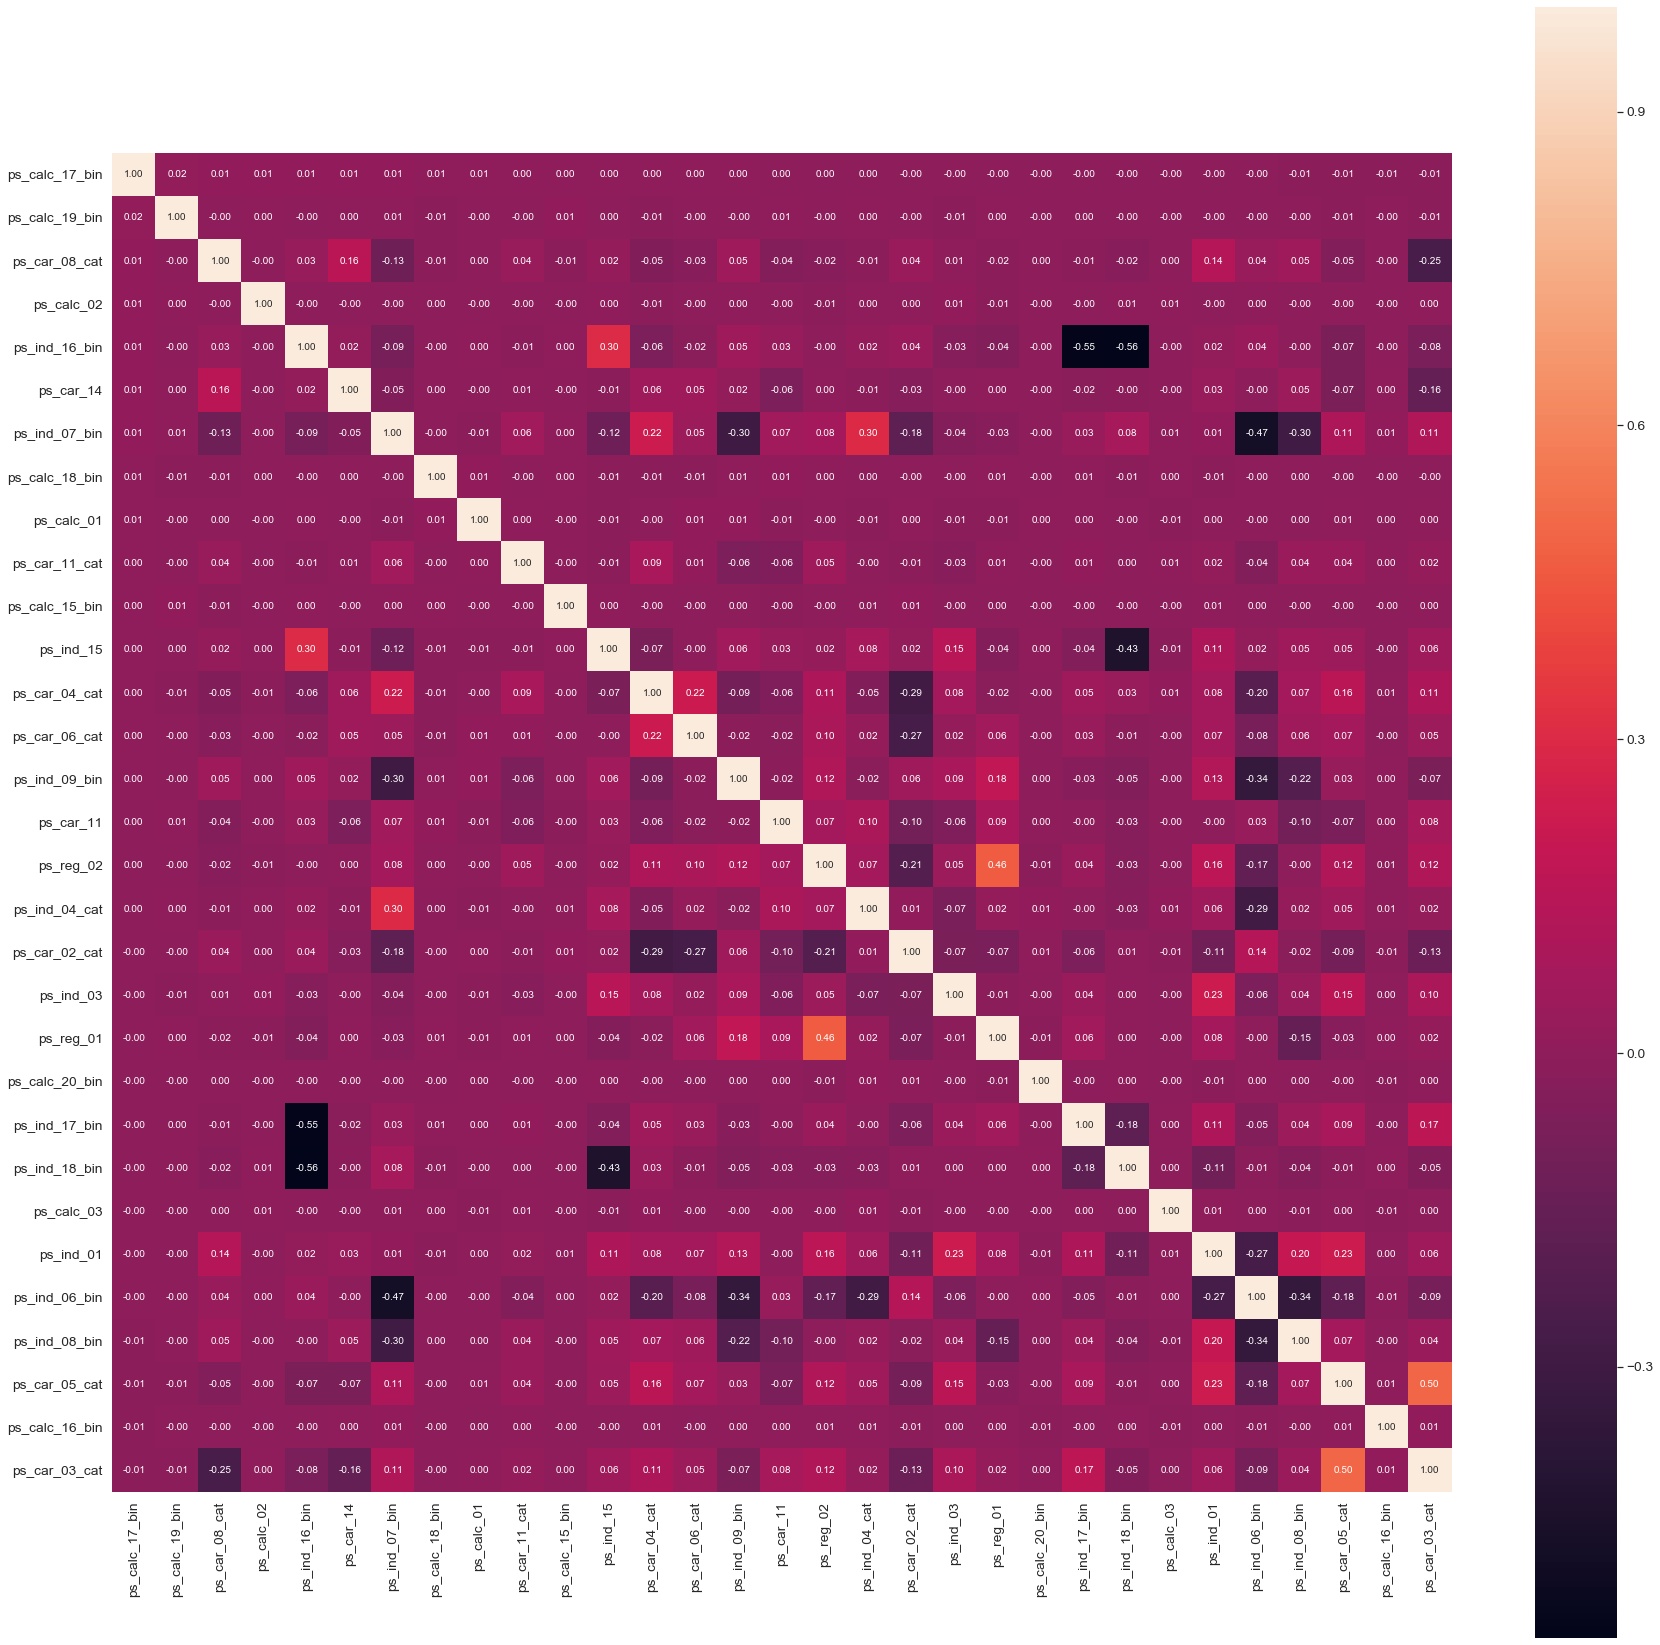

In [20]:
corrmat1 = d_fF_norm_LVar.corr()
k = d_fF_norm_LVar.shape[1] #number of variables for heatmap
cols = corrmat1.nlargest(k, "ps_calc_17_bin")['ps_calc_17_bin'].index
cm = np.corrcoef(d_fF_norm_LVar[cols].values.T)
sns.set(font_scale=1.25)
plt.figure(figsize=(30,30))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', 
                 annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values,)
plt.show()

In [21]:
cort = corrmat1[corrmat1>0.2]
s = corrmat1.unstack()
so = s.sort_values(ascending =False)
so = so[so>=0.2] 
so = so[so<1]
so = so.iloc[::2]
print("Below Variables show, strong correlation")
print(so)

Below Variables show, strong correlation
ps_car_03_cat  ps_car_05_cat    0.496874
ps_reg_02      ps_reg_01        0.464776
ps_ind_15      ps_ind_16_bin    0.303582
ps_ind_04_cat  ps_ind_07_bin    0.297740
ps_ind_03      ps_ind_01        0.226066
ps_car_05_cat  ps_ind_01        0.225003
ps_car_04_cat  ps_ind_07_bin    0.224710
               ps_car_06_cat    0.216243
ps_ind_01      ps_ind_08_bin    0.201107
dtype: float64


In [22]:
HCor = []
for i in range(len(so)):
    HCor.append(so.index[i][0])
d_fF_norm_LVar_HCor = d_fF_norm_LVar.drop(HCor,axis=1)

#### Random Forest Feature Importance

In [23]:
m = RandomForestClassifier(n_estimators=500)
m.fit(d_fF_norm_LVar_HCor, YF).score(d_fF_norm_LVar_HCor, YF)
feature_imp = pd.Series(m.feature_importances_,index=list(d_fF_norm_LVar_HCor.columns)).sort_values(ascending=False)
print(feature_imp)

ps_car_14         0.136415
ps_calc_01        0.111028
ps_calc_03        0.109491
ps_calc_02        0.109426
ps_car_11_cat     0.106629
ps_reg_01         0.082934
ps_car_06_cat     0.072897
ps_car_11         0.037034
ps_calc_17_bin    0.030066
ps_calc_16_bin    0.029158
ps_calc_19_bin    0.028484
ps_calc_18_bin    0.027143
ps_calc_20_bin    0.020744
ps_calc_15_bin    0.018517
ps_car_08_cat     0.012903
ps_ind_16_bin     0.011419
ps_car_02_cat     0.010629
ps_ind_18_bin     0.009222
ps_ind_17_bin     0.007958
ps_ind_06_bin     0.007822
ps_ind_07_bin     0.007290
ps_ind_08_bin     0.006476
ps_ind_09_bin     0.006314
dtype: float64


In [24]:
RF1 = feature_imp[feature_imp.cumsum()<0.91]
d_fF_norm_LVar_HCor_RF = d_fF_norm_LVar_HCor.drop(RF1.index.tolist(),axis=1)
for a in d_fF_norm_LVar_HCor_RF.columns:
    d_fF_norm_LVar_HCor_RF[a]=d_fF_norm_LVar_HCor_RF[a].replace(-1,d_fF_norm_LVar_HCor_RF[a].mean() )

#### Principal Component Analysis

In [25]:
from sklearn.preprocessing import StandardScaler
col_names = d_fF.columns
SS=StandardScaler()
df_SS = SS.fit_transform(d_fF)
df_SS=pd.DataFrame(df_SS, columns=col_names)
df_SS.head()

,ps_calc_17_bin,ps_calc_16_bin,ps_calc_19_bin,ps_calc_18_bin,ps_ind_06_bin,ps_ind_17_bin,ps_ind_16_bin,ps_ind_07_bin,ps_calc_20_bin,ps_calc_15_bin,...,ps_calc_08,ps_calc_07,ps_calc_06,ps_calc_09,ps_calc_12,ps_calc_04,ps_calc_05,ps_reg_03,ps_reg_02,ps_reg_01
0,-1.119109,-1.295468,1.364629,-0.639489,1.351819,-0.42066,0.767195,-0.641321,-0.422322,-0.374709,...,-0.153212,-0.005752,0.98363,1.326060,0.466381,-0.334810,0.980525,0.973279,2.893373,0.252980
1,0.893568,0.771922,-0.732800,1.563747,-0.739744,-0.42066,0.767195,-0.641321,-0.422322,2.668737,...,-0.837042,1.404023,0.23267,0.525232,-1.192159,-0.334810,1.858251,0.465132,0.063562,0.252980
2,0.893568,0.771922,-0.732800,1.563747,-0.739744,-0.42066,0.767195,-0.641321,-0.422322,-0.374709,...,0.530618,-0.005752,-0.51829,2.126889,-0.362889,1.459553,1.858251,-2.080377,-0.408073,-1.163203
3,0.893568,0.771922,-0.732800,-0.639489,-0.739744,-0.42066,-1.303450,1.559281,-0.422322,-0.374709,...,-0.837042,-0.005752,0.23267,1.326060,-0.362889,-0.334810,-0.774926,1.431099,2.893373,0.961071
4,0.893568,0.771922,-0.732800,-0.639489,-0.739744,-0.42066,0.767195,-0.641321,-0.422322,-0.374709,...,-1.520872,-1.415527,0.23267,1.326060,1.295651,1.459553,0.102799,-2.080377,-0.643890,-1.163203


In [26]:
from sklearn.decomposition import PCA
pca = PCA()
new_feat1 = pca.fit_transform(df_SS)
print(np.round(pca.explained_variance_ratio_.cumsum(), 3))
pca = PCA(n_components=8)
new_feat2 = pca.fit_transform(df_SS)
print(new_feat2.shape)
print(np.round(pca.explained_variance_ratio_.cumsum(), 3))
new_feat2_df = pd.DataFrame(new_feat2)

[0.066 0.112 0.152 0.187 0.219 0.249 0.278 0.302 0.324 0.346 0.365 0.384
 0.402 0.421 0.439 0.457 0.475 0.493 0.51  0.528 0.546 0.564 0.581 0.599
 0.616 0.634 0.651 0.668 0.686 0.703 0.72  0.737 0.754 0.771 0.787 0.804
 0.82  0.836 0.851 0.866 0.88  0.893 0.906 0.918 0.93  0.941 0.951 0.961
 0.971 0.979 0.986 0.992 0.996 0.998 1.    1.    1.   ]
(100000, 8)
[0.066 0.112 0.152 0.186 0.218 0.248 0.277 0.301]


## Section 4: Test All the Models

### Section 4.a: SVC with Imbalance Check & Feature Optimization & only 100K Records 

In [30]:
X_tr1, X_val1, Y_tr1, Y_val1 = model_selection.train_test_split(d_fF_norm_LVar_HCor_RF, YF, test_size=0.3,random_state=7)
m = SVC(gamma='auto', probability=True)
m.fit(X_tr1, Y_tr1)

Trn_scr = np.round((m.score(X_tr1, Y_tr1)*100),2)
#msg = "Train Score for :"+"%s: %.2f " % (Trn_scr)
predictions = m.predict(X_val1)
Tst_scr = np.round((accuracy_score(Y_val1, predictions)*100),2)
#msg = "Test Score for  :"+"%s: %.2f" % (name, Tst_scr)
#print(msg)

conf_mat_svc = confusion_matrix(Y_val1, predictions)
#print("Confusion Matrix: \n",conf_mat)

CL_R_svc = classification_report(Y_val1,predictions)

probs = m.predict_proba(X_val1)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate scores
auc = np.round(roc_auc_score(Y_val1, probs),2)
# summarize scores
#print("AUC Score: ",np.round(auc,2))

tn = conf_mat_svc[0][0]
fp = conf_mat_svc[0][1]
fn = conf_mat_svc[1][0]
tp = conf_mat_svc[1][1]

precision_0 = np.round((tn/(tn+fn)),2)
precision_1 = np.round((tp/(fp+tp)),2)                        
recall_0 = np.round((tn/(tn+fp)),2)
recall_1 = np.round((tp/(fn+tp)),2)
            
F1 = 2*((precision_1*recall_1)/(precision_1+recall_1))

Res_Intmdt2 = pd.DataFrame()
Res_Intmdt2["Model"] = ["SupVec"]
Res_Intmdt2["Var"] = ["FET"]
Res_Intmdt2["Train"] = [np.round(Trn_scr,2)]
Res_Intmdt2["Test"] = [np.round(Tst_scr,2)]
Res_Intmdt2["Pre0"] = [np.round(precision_0,2)]
Res_Intmdt2["Pre1"] = [np.round(precision_1,2)]
Res_Intmdt2["Rec0"] = [np.round(recall_0,2)]
Res_Intmdt2["Rec1"] = [np.round(recall_1,2)]
Res_Intmdt2["F1"] = [np.round(F1,2)]
Res_Intmdt2["AUC"] = [np.round(auc,2)]
print(Res_Intmdt2)

    Model  Var  Train   Test  Pre0  Pre1  Rec0  Rec1    F1   AUC
0  SupVec  FET  56.13  56.14  0.56  0.56  0.58  0.54  0.55  0.43


### Section 4.b: SVC with PCA

In [31]:
X_tr2, X_val2, Y_tr2, Y_val2 = model_selection.train_test_split(new_feat2_df, YF, test_size=0.3,random_state=7)
m = SVC(gamma='auto', probability=True)
m.fit(X_tr2, Y_tr2)

Trn_scr = np.round((m.score(X_tr2, Y_tr2)*100),2)
#msg = "Train Score for :"+"%s: %.2f " % (Trn_scr)
predictions = m.predict(X_val2)
Tst_scr = np.round((accuracy_score(Y_val2, predictions)*100),2)
#msg = "Test Score for  :"+"%s: %.2f" % (name, Tst_scr)
#print(msg)

conf_mat_svcpca = confusion_matrix(Y_val2, predictions)
#print("Confusion Matrix: \n",conf_mat)

CL_R_svcpca = classification_report(Y_val1,predictions)

probs = m.predict_proba(X_val2)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate scores
auc = np.round(roc_auc_score(Y_val2, probs),2)
# summarize scores
#print("AUC Score: ",np.round(auc,2))

tn = conf_mat_svcpca[0][0]
fp = conf_mat_svcpca[0][1]
fn = conf_mat_svcpca[1][0]
tp = conf_mat_svcpca[1][1]

precision_0 = np.round((tn/(tn+fn)),2)
precision_1 = np.round((tp/(fp+tp)),2)                        
recall_0 = np.round((tn/(tn+fp)),2)
recall_1 = np.round((tp/(fn+tp)),2)
            
F1 = 2*((precision_1*recall_1)/(precision_1+recall_1))

Res_Intmdt3 = pd.DataFrame()
Res_Intmdt3["Model"] = ["SupVec"]
Res_Intmdt3["Var"] = ["PCA"]
Res_Intmdt3["Train"] = [np.round(Trn_scr,2)]
Res_Intmdt3["Test"] = [np.round(Tst_scr,2)]
Res_Intmdt3["Pre0"] = [np.round(precision_0,2)]
Res_Intmdt3["Pre1"] = [np.round(precision_1,2)]
Res_Intmdt3["Rec0"] = [np.round(recall_0,2)]
Res_Intmdt3["Rec1"] = [np.round(recall_1,2)]
Res_Intmdt3["F1"] = [np.round(F1,2)]
Res_Intmdt3["AUC"] = [np.round(auc,2)]
Res_Intmdt3

,Model,Var,Train,Test,Pre0,Pre1,Rec0,Rec1,F1,AUC
0,RandFo,PCA,61.1,59.1,0.59,0.59,0.63,0.56,0.57,0.5


In [178]:
print(Res_Intmdt3)

    Model  Var  Train  Test  Pre0  Pre1  Rec0  Rec1    F1  AUC
0  RandFo  PCA   61.1  59.1  0.59  0.59  0.63  0.56  0.57  0.5


### Section 4.c: Raw data, with all categories with all the models

In [32]:
spread3 = {"All" :np.arange(0,57)}
d_fF_all = pd.concat([d_fF,YF], axis=1)
CM1, CLR1, Without_pre_process_all = run_models(spread =spread3,d_f=d_fF_all,seed=7,Test_size=0.3)
print(Without_pre_process_all)

    Model  Var   Train   Test  Pre0  Pre1  Rec0  Rec1    F1   AUC
0  XGBoo   All   77.73  67.98  0.68  0.68  0.68  0.68  0.68  0.74
1  AdaBoo  All   59.37  59.82  0.60  0.60  0.62  0.57  0.58  0.64
2  LogReg  All   58.68  59.01  0.59  0.60  0.63  0.55  0.57  0.62
3  LDA     All   58.69  58.92  0.58  0.60  0.64  0.54  0.57  0.62
4  KNearN  All   76.79  63.97  0.66  0.63  0.59  0.69  0.66  0.69
5  CART    All  100.00  78.43  0.85  0.74  0.70  0.87  0.80  0.78
6  NaiveB  All   57.38  57.94  0.56  0.63  0.78  0.38  0.47  0.62
7  SupVec  All   89.82  73.58  0.74  0.73  0.73  0.75  0.74  0.82
8  RandFo  All  100.00  87.91  0.85  0.91  0.92  0.84  0.87  0.93


### Section 4.d: Preprocessed data, with all categories with all the models

In [33]:
spread3 = {"All" :np.arange(0,57)}
CM2, CLR2, With_pre_process_all = run_models(spread =spread3,d_f=df_norm_hot_en,seed=7,Test_size=0.3)
print(With_pre_process_all)

    Model  Var   Train   Test  Pre0  Pre1  Rec0  Rec1    F1   AUC
0  XGBoo   All   76.47  66.78  0.67  0.67  0.67  0.67  0.67  0.73
1  AdaBoo  All   58.93  58.99  0.59  0.59  0.61  0.57  0.58  0.62
2  LogReg  All   57.69  58.27  0.58  0.59  0.62  0.54  0.56  0.61
3  LDA     All   57.66  58.30  0.58  0.59  0.63  0.54  0.56  0.61
4  KNearN  All   76.67  62.97  0.65  0.61  0.57  0.69  0.65  0.68
5  CART    All  100.00  78.36  0.85  0.74  0.69  0.88  0.80  0.78
6  NaiveB  All   55.45  56.02  0.54  0.61  0.80  0.32  0.42  0.60
7  SupVec  All   56.46  56.50  0.57  0.56  0.56  0.57  0.56  0.40
8  RandFo  All  100.00  87.76  0.85  0.91  0.92  0.83  0.87  0.93


### Section 4.e: Test All the Models with Feature classified as is Data (No Preprocessing/No Transformation)

In [34]:
spread1 = {"Bin" :np.arange(0,17), "Cat":np.arange(17,31),"Ind":np.arange(31,35) , "Car":np.arange(35,40) , "Cal":np.arange(40,54) ,"Reg": np.arange(54,57)}
CM3, CLR3, Without_pre_process = run_models(spread =spread1,d_f=df_final1,seed=7,Test_size=0.3)

In [35]:
print(Without_pre_process.reset_index(drop=True))

     Model  Var   Train   Test  Pre0  Pre1  Rec0  Rec1    F1   AUC
0   XGBoo   Bin   57.13  56.27  0.57  0.56  0.56  0.56  0.56  0.58
1   AdaBoo  Bin   55.73  55.83  0.57  0.55  0.53  0.59  0.57  0.58
2   LogReg  Bin   55.73  55.83  0.57  0.55  0.53  0.59  0.57  0.58
3   LDA     Bin   55.73  55.83  0.57  0.55  0.53  0.59  0.57  0.58
4   KNearN  Bin   53.90  52.82  0.53  0.53  0.56  0.50  0.51  0.54
5   CART    Bin   57.88  56.00  0.56  0.56  0.56  0.56  0.56  0.58
6   NaiveB  Bin   54.52  54.73  0.53  0.59  0.79  0.30  0.40  0.58
7   SupVec  Bin   55.75  55.70  0.56  0.55  0.52  0.59  0.57  0.43
8   RandFo  Bin   57.86  55.79  0.56  0.55  0.56  0.56  0.55  0.58
9   XGBoo   Cat   65.26  60.90  0.60  0.62  0.65  0.56  0.59  0.65
10  AdaBoo  Cat   57.89  57.84  0.57  0.59  0.63  0.52  0.55  0.61
11  LogReg  Cat   57.11  57.47  0.57  0.59  0.65  0.49  0.54  0.60
12  LDA     Cat   57.09  57.39  0.57  0.59  0.66  0.49  0.54  0.60
13  KNearN  Cat   72.04  62.19  0.64  0.61  0.58  0.66  0.63  

### Section 4.f: Test All the Models with Feature classified & Preprocessed/Transformed Data

In [36]:
spread2 = {"Bin" :np.arange(0,17),"Ind":np.arange(17,21) , "Car":np.arange(21,26) , "Cal":np.arange(26,40) ,"Reg": np.arange(40,43),"Cat":np.arange(43,226)}
CM4, CLR4, With_pre_process = run_models(spread =spread2,d_f=df_norm_hot_en,seed=7,Test_size=0.3)

In [37]:
print(With_pre_process.reset_index(drop=True))

     Model  Var   Train   Test  Pre0  Pre1  Rec0  Rec1    F1   AUC
0   XGBoo   Bin   57.13  56.27  0.57  0.56  0.56  0.56  0.56  0.58
1   AdaBoo  Bin   55.73  55.83  0.57  0.55  0.53  0.59  0.57  0.58
2   LogReg  Bin   55.73  55.83  0.57  0.55  0.53  0.59  0.57  0.58
3   LDA     Bin   55.73  55.83  0.57  0.55  0.53  0.59  0.57  0.58
4   KNearN  Bin   53.90  52.82  0.53  0.53  0.56  0.50  0.51  0.54
5   CART    Bin   57.88  56.00  0.56  0.56  0.56  0.56  0.56  0.58
6   NaiveB  Bin   54.52  54.73  0.53  0.59  0.79  0.30  0.40  0.58
7   SupVec  Bin   55.75  55.70  0.56  0.55  0.52  0.59  0.57  0.43
8   RandFo  Bin   57.87  55.93  0.56  0.56  0.55  0.57  0.56  0.58
9   XGBoo   Ind   58.01  55.68  0.55  0.56  0.61  0.50  0.53  0.58
10  AdaBoo  Ind   55.09  54.58  0.55  0.54  0.55  0.54  0.54  0.57
11  LogReg  Ind   53.01  52.85  0.53  0.53  0.54  0.52  0.52  0.55
12  LDA     Ind   53.00  52.84  0.53  0.53  0.54  0.52  0.52  0.55
13  KNearN  Ind   53.84  52.54  0.53  0.52  0.54  0.51  0.51  

### Section 4.g: Random Forest on Raw Data with only Calc & Cat Variables

In [41]:
var1 = "C&C"
CM5, CLR5, RF_CatCalc= run_RF(X_train7, X_validation7, Y_train2,Y_validation2, var1)
print(RF_CatCalc)

    Model  Var  Train   Test  Pre0  Pre1  Rec0  Rec1    F1   AUC
0  RandFo  C&C  100.0  87.91  0.85  0.92  0.93  0.83  0.87  0.93


### Section 4.h: Random Forest on Preprocessed Data with only Calc & Cat Variables

In [42]:
var2 ="C&C"
CM6, CLR6,  RF_CatCalc1= run_RF(X_train8, X_validation8, Y_train8,Y_validation8, var2)
print(RF_CatCalc1)

    Model  Var  Train   Test  Pre0  Pre1  Rec0  Rec1   F1  AUC
0  RandFo  C&C  100.0  100.0   1.0   1.0   1.0   1.0  1.0  1.0


## Section 5: Multilayer Perceptron Classification

### Section 5.a: Generate the various acrchitectures with varying Hidden Layer Size and varying Neurons

In [43]:
Y = df_norm_hot_en["target"]
X = df_norm_hot_en.drop("target", axis=1)
Input_features = X.shape[1]
hidden_Architecture =[]
t_3n = []
f = two_third(Input_features)
hid_architecture = []
ln =len(f)-1
for i in range(ln):
    if i==0:
        hid_architecture.append(tuple(f[0:1]))
    else:
        hid_architecture.append(tuple(f[0:i+1]))
hid_architecture

[(151,),
 (151, 101),
 (151, 101, 67),
 (151, 101, 67, 45),
 (151, 101, 67, 45, 30),
 (151, 101, 67, 45, 30, 20),
 (151, 101, 67, 45, 30, 20, 13),
 (151, 101, 67, 45, 30, 20, 13, 9),
 (151, 101, 67, 45, 30, 20, 13, 9, 6),
 (151, 101, 67, 45, 30, 20, 13, 9, 6, 4),
 (151, 101, 67, 45, 30, 20, 13, 9, 6, 4, 3),
 (151, 101, 67, 45, 30, 20, 13, 9, 6, 4, 3, 2)]

### Section 5.b: Train and Test the MLP for the various architectures and iterations

##### Section 5.b.1: MLP with hid_architecture (above output cell), and epochs of [10,20,25,50,70,100,200]

In [48]:
#MLP with all the architectures(hid_architecture) defined with epochs from 10 to 500
epochs =[10,20,25,50,70,100,200]
CM10, CLR10, MLP_Res = run_mlp(hid_architecture, epochs,X,Y)

C:\Users\nishant.l\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\nishant.l\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\nishant.l\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\nishant.l\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score

C:\Users\nishant.l\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\nishant.l\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nishant.l\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\nishant.l\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimizati

C:\Users\nishant.l\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nishant.l\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\nishant.l\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\nishant.l\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

C:\Users\nishant.l\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nishant.l\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\nishant.l\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nishant.l\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in longlong_scal

C:\Users\nishant.l\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nishant.l\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\nishant.l\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nishant.l\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in longlong_scal

C:\Users\nishant.l\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nishant.l\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\nishant.l\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nishant.l\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in longlong_scal

In [90]:
MLP_Res["Train"] = np.round(MLP_Res["Train"]*100,2)
print(MLP_Res.reset_index(drop=True).head(60))

     Arch  Epoch  Train   Test  Loss  Pre0  Pre1  Rec0  Rec1    F1   AUC
0   1:1:1     10   52.0  52.05  0.68  0.51  0.76  0.98  0.05  0.09  0.53
1   1:1:1     20   59.0  59.48  0.68  0.57  0.64  0.78  0.41  0.50  0.61
2   1:1:1     25   59.0  59.48  0.68  0.57  0.64  0.78  0.41  0.50  0.61
3   1:1:1     50   59.0  59.48  0.68  0.57  0.64  0.78  0.41  0.50  0.61
4   1:1:1     70   59.0  59.48  0.68  0.57  0.64  0.78  0.41  0.50  0.61
5   1:1:1    100   59.0  59.48  0.68  0.57  0.64  0.78  0.41  0.50  0.61
6   1:1:1    200   59.0  59.48  0.68  0.57  0.64  0.78  0.41  0.50  0.61
7   1:2:1     10   58.0  58.62  0.68  0.56  0.65  0.81  0.36  0.46  0.62
8   1:2:1     20   59.0  60.17  0.67  0.60  0.60  0.62  0.59  0.59  0.63
9   1:2:1     25   59.0  60.17  0.67  0.60  0.60  0.62  0.59  0.59  0.63
10  1:2:1     50   59.0  60.17  0.67  0.60  0.60  0.62  0.59  0.59  0.63
11  1:2:1     70   59.0  60.17  0.67  0.60  0.60  0.62  0.59  0.59  0.63
12  1:2:1    100   59.0  60.17  0.67  0.60  0.60  0

In [180]:
print(MLP_Res.reset_index(drop=True).tail(24))

      Arch  Epoch  Train   Test  Loss  Pre0  Pre1  Rec0  Rec1    F1   AUC
60   1:9:1     70   50.0  50.29  0.69   0.5   NaN   1.0   0.0   NaN  0.50
61   1:9:1    100   50.0  50.29  0.69   0.5   NaN   1.0   0.0   NaN  0.50
62   1:9:1    200   50.0  50.29  0.69   0.5   NaN   1.0   0.0   NaN  0.50
63  1:10:1     10   50.0  49.71  0.69   NaN   0.5   0.0   1.0  0.67  0.50
64  1:10:1     20   50.0  49.71  0.69   NaN   0.5   0.0   1.0  0.67  0.50
65  1:10:1     25   50.0  49.71  0.69   NaN   0.5   0.0   1.0  0.67  0.50
66  1:10:1     50   50.0  49.71  0.69   NaN   0.5   0.0   1.0  0.67  0.50
67  1:10:1     70   50.0  49.71  0.69   NaN   0.5   0.0   1.0  0.67  0.50
68  1:10:1    100   50.0  49.71  0.69   NaN   0.5   0.0   1.0  0.67  0.50
69  1:10:1    200   50.0  49.71  0.69   NaN   0.5   0.0   1.0  0.67  0.50
70  1:11:1     10   50.0  50.29  0.69   0.5   NaN   1.0   0.0   NaN  0.50
71  1:11:1     20   50.0  49.71  0.69   NaN   0.5   0.0   1.0  0.67  0.50
72  1:11:1     25   50.0  49.71  0.69 

##### Section 5.b.2: MLP with all the architectures starting from 1st 2/3 layer of input (2/3rd of input feat =151) features defined with epochs from 10 to 80

In [ ]:
epochs =[10,20,25,50,70,80]
hid_architecture2 =[(151,),(151,101),(151,101,67),(151,101,67,45)]
CM11, CLR11, MLP_Res2 = run_mlp(hid_architecture2, epochs,X,Y)

In [89]:
MLP_Res2["Train"] = np.round(MLP_Res2["Train"]*100,2)
print(MLP_Res2.reset_index(drop=True))

     Arch  Epoch  Train   Test  Loss  Pre0  Pre1  Rec0  Rec1    F1   AUC
0   1:1:1     10   52.0  52.05  0.68  0.51  0.76  0.98  0.05  0.09  0.53
1   1:1:1     20   59.0  59.48  0.68  0.57  0.64  0.78  0.41  0.50  0.61
2   1:1:1     25   59.0  59.48  0.68  0.57  0.64  0.78  0.41  0.50  0.61
3   1:1:1     50   59.0  59.48  0.68  0.57  0.64  0.78  0.41  0.50  0.61
4   1:1:1     70   59.0  59.48  0.68  0.57  0.64  0.78  0.41  0.50  0.61
5   1:1:1     80   59.0  59.48  0.68  0.57  0.64  0.78  0.41  0.50  0.61
6   1:2:1     10   58.0  58.62  0.68  0.56  0.65  0.81  0.36  0.46  0.62
7   1:2:1     20   59.0  60.17  0.67  0.60  0.60  0.62  0.59  0.59  0.63
8   1:2:1     25   59.0  60.17  0.67  0.60  0.60  0.62  0.59  0.59  0.63
9   1:2:1     50   59.0  60.17  0.67  0.60  0.60  0.62  0.59  0.59  0.63
10  1:2:1     70   59.0  60.17  0.67  0.60  0.60  0.62  0.59  0.59  0.63
11  1:2:1     80   59.0  60.17  0.67  0.60  0.60  0.62  0.59  0.59  0.63
12  1:3:1     10   50.0  50.29  0.69  0.50   NaN  1

##### Section 5.b.3: MLP with all the architectures starting from 2nd 2/3 layer of input (2 nd 2/3rd of input feat =101) features defined with epochs from 10 to 30¶

In [ ]:
epochs =[10,20,21,22,23,24,25,30]
hid_architecture3 =[(101,),(101,67),(101,67,45)]
CM12, CLR12, MLP_Res3 = run_mlp(hid_architecture3, epochs,X,Y)

In [53]:
print(MLP_Res3.reset_index(drop=True))

     Arch  Epoch  Train   Test  Loss  Pre0  Pre1  Rec0  Rec1    F1   AUC
0   1:1:1     10   0.59  59.21  0.68  0.63  0.57  0.47  0.72  0.64  0.63
1   1:1:1     20   0.60  59.75  0.68  0.61  0.59  0.57  0.62  0.60  0.63
2   1:1:1     21   0.60  59.75  0.68  0.61  0.59  0.57  0.62  0.60  0.63
3   1:1:1     22   0.60  59.75  0.68  0.61  0.59  0.57  0.62  0.60  0.63
4   1:1:1     23   0.60  59.75  0.68  0.61  0.59  0.57  0.62  0.60  0.63
5   1:1:1     24   0.60  59.75  0.68  0.61  0.59  0.57  0.62  0.60  0.63
6   1:1:1     25   0.60  59.75  0.68  0.61  0.59  0.57  0.62  0.60  0.63
7   1:1:1     30   0.60  59.75  0.68  0.61  0.59  0.57  0.62  0.60  0.63
8   1:2:1     10   0.50  50.29  0.69  0.50   NaN  1.00  0.00   NaN  0.50
9   1:2:1     20   0.50  50.29  0.69  0.50   NaN  1.00  0.00   NaN  0.50
10  1:2:1     21   0.50  50.29  0.69  0.50   NaN  1.00  0.00   NaN  0.50
11  1:2:1     22   0.50  50.29  0.69  0.50   NaN  1.00  0.00   NaN  0.50
12  1:2:1     23   0.50  49.71  0.69   NaN  0.50  0

##### Section 5.b.4: MLP with all the architectures starting from 2nd 2/3 layer of input features(2nd 2/3rd of input feat =101) defined with epochs from 10 to 70

In [ ]:
epochs =[10,23,25,30,50,70]
hid_architecture4 =[(101,67,45),(101,67,45,30)]
CM13, CLR13, MLP_Res4 = run_mlp(hid_architecture4, epochs,X,Y)

In [85]:
MLP_Res4["Train"] = np.round(MLP_Res4["Train"]*100,2)
print(MLP_Res4.reset_index(drop=True))

     Arch  Epoch  Train   Test  Loss  Pre0  Pre1  Rec0  Rec1    F1   AUC
0   1:3:1     10   59.0  59.85  0.67  0.58  0.64  0.76  0.43  0.51  0.64
1   1:3:1     23   53.0  53.83  0.69  0.52  0.69  0.94  0.13  0.22  0.54
2   1:3:1     25   53.0  53.83  0.69  0.52  0.69  0.94  0.13  0.22  0.54
3   1:3:1     30   53.0  53.83  0.69  0.52  0.69  0.94  0.13  0.22  0.54
4   1:3:1     50   53.0  53.83  0.69  0.52  0.69  0.94  0.13  0.22  0.54
5   1:3:1     70   53.0  53.83  0.69  0.52  0.69  0.94  0.13  0.22  0.54
6   1:4:1     10   50.0  49.71  0.69   NaN  0.50  0.00  1.00  0.67  0.50
7   1:4:1     23   50.0  50.29  0.69  0.50   NaN  1.00  0.00   NaN  0.50
8   1:4:1     25   50.0  50.29  0.69  0.50   NaN  1.00  0.00   NaN  0.50
9   1:4:1     30   50.0  50.29  0.69  0.50   NaN  1.00  0.00   NaN  0.50
10  1:4:1     50   50.0  50.29  0.69  0.50   NaN  1.00  0.00   NaN  0.50
11  1:4:1     70   50.0  50.29  0.69  0.50   NaN  1.00  0.00   NaN  0.50


##### Section 5.b.5: MLP with all the architectures starting from 3rd 2/3 layer of input features(3rd 2/3rd of input feat =67) defined with epochs from 10 to 70

In [ ]:
epochs =[10,23,25,30,50,70]
hid_architecture5 =[(67,45),(67,45,30)]
CM14, CLR14, MLP_Res5 = run_mlp(hid_architecture5, epochs,X,Y)

In [185]:
print(MLP_Res5.reset_index(drop=True))

     Arch  Epoch  Train   Test  Loss  Pre0  Pre1  Rec0  Rec1    F1   AUC
0   1:2:1     10   50.0  50.29  0.69  0.50   NaN  1.00  0.00   NaN  0.50
1   1:2:1     23   50.0  49.71  0.69   NaN  0.50  0.00  1.00  0.67  0.50
2   1:2:1     25   50.0  49.71  0.69   NaN  0.50  0.00  1.00  0.67  0.50
3   1:2:1     30   50.0  49.71  0.69   NaN  0.50  0.00  1.00  0.67  0.50
4   1:2:1     50   50.0  49.71  0.69   NaN  0.50  0.00  1.00  0.67  0.50
5   1:2:1     70   50.0  49.71  0.69   NaN  0.50  0.00  1.00  0.67  0.50
6   1:3:1     10   57.0  56.28  0.68  0.64  0.54  0.30  0.83  0.65  0.57
7   1:3:1     23   58.0  58.59  0.68  0.56  0.63  0.77  0.40  0.49  0.59
8   1:3:1     25   58.0  58.59  0.68  0.56  0.63  0.77  0.40  0.49  0.59
9   1:3:1     30   58.0  58.59  0.68  0.56  0.63  0.77  0.40  0.49  0.59
10  1:3:1     50   58.0  58.59  0.68  0.56  0.63  0.77  0.40  0.49  0.59
11  1:3:1     70   58.0  58.59  0.68  0.56  0.63  0.77  0.40  0.49  0.59


##### Section 5.b.6: MLP with all the architectures starting from 4th 2/3 layer of input features(4th 2/3rd of input feat =45) defined with epochs from 10 to 30

In [176]:
epochs =[10,23,25,30]
hid_architecture6 =[(45,30),(45,30,20)]
CM15, CLR15, MLP_Res6 = run_mlp(hid_architecture6, epochs,X,Y)

C:\Users\nishant.l\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\nishant.l\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\nishant.l\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nishant.l\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50

In [186]:
print(MLP_Res6.reset_index(drop=True))

    Arch  Epoch  Train   Test  Loss  Pre0  Pre1  Rec0  Rec1    F1   AUC
0  1:2:1     10  58.16  58.52  0.67  0.63  0.56  0.41  0.76  0.64  0.64
1  1:2:1     23  59.50  60.00  0.67  0.60  0.60  0.61  0.59  0.59  0.64
2  1:2:1     25  59.50  60.00  0.67  0.60  0.60  0.61  0.59  0.59  0.64
3  1:2:1     30  59.50  60.00  0.67  0.60  0.60  0.61  0.59  0.59  0.64
4  1:3:1     10  50.12  49.71  0.69   NaN  0.50  0.00  1.00  0.67  0.50
5  1:3:1     23  49.88  50.29  0.69  0.50   NaN  1.00  0.00   NaN  0.50
6  1:3:1     25  49.88  50.29  0.69  0.50   NaN  1.00  0.00   NaN  0.50
7  1:3:1     30  49.88  50.29  0.69  0.50   NaN  1.00  0.00   NaN  0.50


##### Section 5.b.7: MLP with all the architectures starting from 5th 2/3 layer of input features(5th 2/3rd of input feat =30) defined with epochs from 10 to 70

In [61]:
epochs =[10,23,25,30,50,70]
hid_architecture7 =[(30,20),(30,20,13)]
CM16, CLR16, MLP_Res7 = run_mlp(hid_architecture7, epochs,X,Y)

C:\Users\nishant.l\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\nishant.l\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nishant.l\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\nishant.l\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

In [88]:
MLP_Res7["Train"] = np.round(MLP_Res7["Train"]*100,2)
print(MLP_Res7.reset_index(drop=True))

     Arch  Epoch  Train   Test  Loss  Pre0  Pre1  Rec0  Rec1    F1  AUC
0   1:2:1     10   50.0  50.29  0.69   0.5   NaN   1.0   0.0   NaN  0.5
1   1:2:1     23   50.0  50.29  0.69   0.5   NaN   1.0   0.0   NaN  0.5
2   1:2:1     25   50.0  50.29  0.69   0.5   NaN   1.0   0.0   NaN  0.5
3   1:2:1     30   50.0  50.29  0.69   0.5   NaN   1.0   0.0   NaN  0.5
4   1:2:1     50   50.0  50.29  0.69   0.5   NaN   1.0   0.0   NaN  0.5
5   1:2:1     70   50.0  50.29  0.69   0.5   NaN   1.0   0.0   NaN  0.5
6   1:3:1     10   50.0  49.71  0.69   NaN   0.5   0.0   1.0  0.67  0.5
7   1:3:1     23   50.0  50.29  0.69   0.5   NaN   1.0   0.0   NaN  0.5
8   1:3:1     25   50.0  50.29  0.69   0.5   NaN   1.0   0.0   NaN  0.5
9   1:3:1     30   50.0  50.29  0.69   0.5   NaN   1.0   0.0   NaN  0.5
10  1:3:1     50   50.0  50.29  0.69   0.5   NaN   1.0   0.0   NaN  0.5
11  1:3:1     70   50.0  50.29  0.69   0.5   NaN   1.0   0.0   NaN  0.5


##### Section 5.b.8: MLP with 1 hidden layer with neurons in the range 90 to 180

In [154]:
hid_architecture8 =[]
hid_architecture9 =[]
for i in range(90,180,1):
    hid_architecture8.append((i))
    hid_architecture9.append( tuple(hid_architecture8[i-90:i+1-90:],))

In [ ]:
epochs =[10,20,23,25]
CM17, CLR17, MLP_Res8 = run_mlp(hid_architecture9, epochs,nn = True,X,Y)
Audio(sound_file,autoplay=True)

In [187]:
print(MLP_Res8)

    Arch  Epoch  Train   Test  Loss  Pre0  Pre1  Rec0  Rec1    F1   AUC
0     90     10  49.88  50.29  0.69  0.50   NaN  1.00  0.00   NaN  0.50
1     90     20  49.88  50.29  0.69  0.50   NaN  1.00  0.00   NaN  0.50
2     90     23  49.88  50.29  0.69  0.50   NaN  1.00  0.00   NaN  0.50
3     90     25  50.12  49.71  0.69   NaN  0.50  0.00  1.00  0.67  0.50
0     91     10  59.16  59.57  0.68  0.62  0.58  0.52  0.67  0.62  0.63
1     91     20  59.06  59.88  0.68  0.62  0.58  0.53  0.67  0.62  0.63
2     91     23  59.06  59.88  0.68  0.62  0.58  0.53  0.67  0.62  0.63
3     91     25  59.06  59.88  0.68  0.62  0.58  0.53  0.67  0.62  0.63
0     92     10  59.32  59.94  0.67  0.59  0.61  0.68  0.52  0.56  0.63
1     92     20  59.34  59.46  0.68  0.61  0.58  0.54  0.65  0.61  0.63
2     92     23  59.45  60.10  0.67  0.60  0.60  0.62  0.59  0.59  0.64
3     92     25  59.45  60.10  0.67  0.60  0.60  0.62  0.59  0.59  0.64
0     93     10  50.12  49.71  0.69   NaN  0.50  0.00  1.00  0.6

## Section 6: Miscellaneous Executions

#### Section 6.a Random Forest Without Binary

In [63]:
print("--------------------------------")
m = RandomForestClassifier(n_estimators=100)
m.fit(X_train2, Y_train2).score(X_train2, Y_train2)
msg = "Train Score for :"+" %.2f " % (np.round((m.fit(X_train2, Y_train2).score(X_train2, Y_train2)*100),2))
print(msg)

predictions = m.predict(X_validation2)
msg = "Test Score for  :"+" %.2f" % ( np.round((accuracy_score(Y_validation2, predictions)*100),2))
print(msg)
conf_mat = confusion_matrix(Y_validation2, predictions)
print("Confusion Matrix: \n",conf_mat)
Cl_R = classification_report(Y_validation2, predictions)
print("Classification Report: \n",Cl_R)
feature_imp = pd.Series(m.feature_importances_,index=list(X_train2.columns)).sort_values(ascending=False)
print(feature_imp)

--------------------------------
Train Score for : 100.00 
Test Score for  : 87.36
Confusion Matrix: 
 [[13686  1401]
 [ 2392 12521]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.91      0.88     15087
           1       0.90      0.84      0.87     14913

    accuracy                           0.87     30000
   macro avg       0.88      0.87      0.87     30000
weighted avg       0.88      0.87      0.87     30000

ps_car_13        0.074375
ps_reg_03        0.064079
ps_car_14        0.049168
ps_calc_10       0.043640
ps_calc_14       0.043294
ps_car_11_cat    0.041091
ps_calc_11       0.040200
ps_calc_01       0.039538
ps_calc_02       0.039346
ps_calc_03       0.039276
ps_reg_02        0.036074
ps_calc_13       0.034084
ps_car_15        0.032016
ps_calc_08       0.031754
ps_calc_07       0.031543
ps_calc_06       0.030421
ps_reg_01        0.029757
ps_calc_09       0.029262
ps_car_06_cat    0.028348
ps_calc_04       0.0

#### Section 6.b: Random Forest Without Binary & Reg

In [64]:
print("--------------------------------")
m = RandomForestClassifier(n_estimators=500)
m.fit(X_train3, Y_train2).score(X_train3, Y_train2)
msg = "Train Score for :"+" %.2f " % (np.round((m.fit(X_train3, Y_train2).score(X_train3, Y_train2)*100),2))
print(msg)

predictions = m.predict(X_validation3)
msg = "Test Score for  :"+" %.2f" % ( np.round((accuracy_score(Y_validation2, predictions)*100),2))
print(msg)
print("Classification Report: \n",classification_report(Y_validation2, predictions))
feature_imp = pd.Series(m.feature_importances_,index=list(X_train3.columns)).sort_values(ascending=False)
print(feature_imp)

--------------------------------
Train Score for : 100.00 
Test Score for  : 87.84
Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.92      0.88     15087
           1       0.91      0.84      0.87     14913

    accuracy                           0.88     30000
   macro avg       0.88      0.88      0.88     30000
weighted avg       0.88      0.88      0.88     30000

ps_car_13        0.084316
ps_car_14        0.054259
ps_calc_10       0.051493
ps_calc_14       0.050326
ps_calc_11       0.047164
ps_calc_03       0.046284
ps_calc_01       0.046277
ps_calc_02       0.045966
ps_car_11_cat    0.044552
ps_calc_13       0.040508
ps_calc_08       0.037986
ps_calc_07       0.037317
ps_car_15        0.036325
ps_calc_06       0.036093
ps_calc_09       0.034822
ps_calc_04       0.032687
ps_calc_05       0.032340
ps_calc_12       0.031939
ps_car_06_cat    0.031364
ps_car_12        0.027649
ps_car_01_cat    0.026919
ps_ind_02_cat    0.

#### Section 6.c: Random Forest Without Binary, Cat & Reg

In [65]:
print("--------------------------------")
m = RandomForestClassifier(n_estimators=500)
f = m.fit(X_train4, Y_train2)
score = f.score(X_train4, Y_train2)
msg = "Train Score for :"+" %.2f " % (np.round((score*100),2))
print(msg)

predictions = m.predict(X_validation4)
msg = "Test Score for  :"+" %.2f" % ( np.round((accuracy_score(Y_validation2, predictions)*100),2))
print(msg)
print("Classification Report: \n",classification_report(Y_validation2, predictions))
feature_imp = pd.Series(m.feature_importances_,index=list(X_train4.columns)).sort_values(ascending=False)
print(feature_imp)

--------------------------------
Train Score for : 100.00 
Test Score for  : 88.08
Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.94      0.89     15087
           1       0.93      0.82      0.87     14913

    accuracy                           0.88     30000
   macro avg       0.89      0.88      0.88     30000
weighted avg       0.89      0.88      0.88     30000

ps_car_13     0.115735
ps_car_14     0.080640
ps_calc_10    0.064869
ps_calc_14    0.061900
ps_calc_11    0.059258
ps_calc_01    0.057475
ps_calc_02    0.057130
ps_calc_03    0.056187
ps_calc_13    0.049391
ps_calc_08    0.047251
ps_calc_07    0.046238
ps_calc_06    0.044564
ps_car_15     0.042861
ps_calc_09    0.042058
ps_calc_04    0.040053
ps_calc_05    0.039992
ps_calc_12    0.039357
ps_car_12     0.035598
ps_car_11     0.019442
dtype: float64


#### Section 6.d: Random Forest Without Binary, Cat, Car & Reg

In [66]:
print("--------------------------------")
m = RandomForestClassifier(n_estimators=500)
f = m.fit(X_train5, Y_train2)
score = f.score(X_train5, Y_train2)
msg = "Train Score for :"+" %.2f " % (np.round((score*100),2))
print(msg)

predictions = m.predict(X_validation5)
msg = "Test Score for  :"+" %.2f" % ( np.round((accuracy_score(Y_validation2, predictions)*100),2))
print(msg)
print("Classification Report: \n",classification_report(Y_validation2, predictions))
feature_imp = pd.Series(m.feature_importances_,index=list(X_train5.columns)).sort_values(ascending=False)
print(feature_imp)

--------------------------------
Train Score for : 100.00 
Test Score for  : 89.56
Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.98      0.90     15087
           1       0.98      0.81      0.88     14913

    accuracy                           0.90     30000
   macro avg       0.91      0.90      0.89     30000
weighted avg       0.91      0.90      0.89     30000

ps_calc_10    0.092685
ps_calc_11    0.086705
ps_calc_14    0.086064
ps_calc_02    0.082154
ps_calc_01    0.080181
ps_calc_03    0.075845
ps_calc_13    0.070660
ps_calc_08    0.068153
ps_calc_06    0.064869
ps_calc_07    0.063106
ps_calc_09    0.059251
ps_calc_05    0.058025
ps_calc_12    0.057002
ps_calc_04    0.055300
dtype: float64


#### Section 6.e: Random Forest Without Binary, Cat, Car, Calc & Reg

In [69]:
print("--------------------------------")
m = RandomForestClassifier(n_estimators=600)
f = m.fit(X_train6, Y_train2)
score = f.score(X_train6, Y_train2)
msg = "Train Score for :"+" %.2f " % (np.round((score*100),2))
print(msg)

predictions = m.predict(X_validation6)
msg = "Test Score for  :"+" %.2f" % ( np.round((accuracy_score(Y_validation2, predictions)*100),2))
print(msg)
print("Classification Report: \n",classification_report(Y_validation2, predictions))
feature_imp = pd.Series(m.feature_importances_,index=list(X_train6.columns)).sort_values(ascending=False)
print(feature_imp)

--------------------------------
Train Score for : 100.00 
Test Score for  : 87.89
Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.93      0.89     15087
           1       0.92      0.83      0.87     14913

    accuracy                           0.88     30000
   macro avg       0.88      0.88      0.88     30000
weighted avg       0.88      0.88      0.88     30000

ps_car_13     0.134438
ps_car_14     0.089039
ps_calc_10    0.073787
ps_calc_14    0.070639
ps_calc_11    0.067826
ps_calc_01    0.065736
ps_calc_02    0.064938
ps_calc_03    0.064538
ps_calc_13    0.057082
ps_calc_08    0.054036
ps_calc_07    0.052486
ps_calc_06    0.050793
ps_calc_09    0.048393
ps_car_15     0.047031
ps_car_12     0.038307
ps_car_11     0.020932
dtype: float64


#### Section 6.f: XG Boost with as is complete Data

In [ ]:
Xgb = XGBClassifier()
Xgb.fit(X_trainF, Y_trainF)
Xgb_score = Xgb.fit(X_trainF, Y_trainF).score(X_trainF, Y_trainF)

msg = "Train Score for :"+" %.2f " % (np.round((Xgb_score*100),2))
print(msg)

predictions = Xgb.predict(X_validationF)
msg = "Test Score for  :"+" %.2f" % ( np.round((accuracy_score(Y_validationF, predictions)*100),2))
print(msg)
print("Classification Report: \n",classification_report(Y_validationF, predictions))

plot_importance(Xgb)
plt.show()
Audio(sound_file,autoplay=True)

#### Section 6.g: XG Boost with preprocessed complete Data

In [ ]:
Xgb = XGBClassifier()
Xgb.fit(X_train9, Y_train9)
Xgb_score = Xgb.fit(X_train9, Y_train9).score(X_train9, Y_train9)

msg = "Train Score for :"+" %.2f " % (np.round((Xgb_score*100),2))
print(msg)

predictions = Xgb.predict(X_validation9)
msg = "Test Score for  :"+" %.2f" % ( np.round((accuracy_score(Y_validation9, predictions)*100),2))
print(msg)
print("Classification Report: \n",classification_report(Y_validation9, predictions))

plot_importance(Xgb)
plt.show()

In [134]:
for h in hid_architecture:
    print(h)
    print(str(np.sum(h)))

(151,)
151
(151, 101)
252
(151, 101, 67)
319
(151, 101, 67, 45)
364
(151, 101, 67, 45, 30)
394
(151, 101, 67, 45, 30, 20)
414
(151, 101, 67, 45, 30, 20, 13)
427
(151, 101, 67, 45, 30, 20, 13, 9)
436
(151, 101, 67, 45, 30, 20, 13, 9, 6)
442
(151, 101, 67, 45, 30, 20, 13, 9, 6, 4)
446
(151, 101, 67, 45, 30, 20, 13, 9, 6, 4, 3)
449
(151, 101, 67, 45, 30, 20, 13, 9, 6, 4, 3, 2)
451


In [135]:
hid_architecture9[0:2]

[(90,), (91,)]

In [136]:
u= hid_architecture9[0]
str(np.sum(u))

'90'